In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import gc
import os
import pyarrow
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

conn = duckdb.connect()

### Download automático do dataset

In [ ]:
import duckdb

url = "https://data.cityofnewyork.us/resource/5zyy-y8am.csv?$limit=64200"

query = f"""
SELECT * 
EXCLUDE (default_values, property_notes)
FROM read_csv_auto('{url}', ignore_errors=True)
LIMIT 70000
"""

df = duckdb.query(query).df()
df = df.replace('Not Available', None)

df.to_parquet('nyc_energy_water_data.parquet', engine="pyarrow", compression="snappy")


### Estrutura básica do dataset

In [ ]:
df = conn.execute("SELECT * FROM read_parquet('nyc_energy_water_data.parquet')").fetch_df()
# Verificar a estrutura dos dados 
print("ESTRUTURA DO DATASET")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Colunas: {list(df.columns)}")
print("\nPrimeiras linhas:")
df.head()

In [ ]:
# Análise de dados faltantes
missing_analysis = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_analysis / len(df) * 100).round(2)

print("COLUNAS COM MAIS DE 50% DE DADOS FALTANTES:")
high_missing = missing_percent[missing_percent > 50]
display(high_missing.head(25))

### Limpeza dos dados

In [35]:
# 1. Selecionar colunas relevantes para análise de eficiência energética
selected_columns = [
    'property_id', 'property_name', 'primary_property_type', 'borough',
    'year_built', 'number_of_buildings', 'occupancy',
    'energy_star_score', 'site_eui_kbtu_ft', 'weather_normalized_site_eui',
    'source_eui_kbtu_ft', 'site_energy_use_kbtu', 'property_gfa_calculated',
    'electricity_use_grid_purchase', 'natural_gas_use_kbtu',
    'total_location_based_ghg', 'latitude', 'longitude'
]

df_selected = df[selected_columns].copy()

display(df_selected.head(5))

# Verificar dados faltantes iniciais
print("\nDADOS FALTANTES NAS COLUNAS SELECIONADAS:")
missing_initial = df_selected.isnull().sum().sort_values(ascending=False)
missing_percent_initial = (missing_initial / len(df_selected) * 100).round(2)

for col, count in missing_initial.head(10).items():
    if count > 0:
        print(f"{col}: {count} ({missing_percent_initial[col]}%)")



,property_id,property_name,primary_property_type,borough,year_built,number_of_buildings,occupancy,energy_star_score,site_eui_kbtu_ft,weather_normalized_site_eui,source_eui_kbtu_ft,site_energy_use_kbtu,property_gfa_calculated,electricity_use_grid_purchase,natural_gas_use_kbtu,total_location_based_ghg,latitude,longitude
0,6414946,58-01 Grand Avenue,Non-Refrigerated Warehouse,QUEENS,1930,1,50,96,10.1,10.6,13,520173,51749.0,70973,449200,29.9,40.719667,-73.911197
1,9793770,1870 Pelham Parkway South,Multifamily Housing,BRONX,1960,1,75,61,58.5,58.5,115.7,3096670.2,52941.0,1642970.2,1453700,216.1,40.855488,-73.830726
2,10177418,Central Building,Mixed Use Property,QUEENS,1941,1,50,None,63.8,64.1,136.4,2244816.6,35196.0,1395451.2,849365.4,163.1,40.604320,-73.753009
3,13511507,215 East 99th Street,Multifamily Housing,MANHATTAN,1898,1,100,64,68.2,69,107.4,7314028.3,107234.0,2191128.4,5122899.9,457.3,40.786963,-73.947537
4,14009907,23-25 31 Street,Medical Office,QUEENS,1911,1,80,98,51.1,50.9,140,3838751.8,75191.0,3711191.8,111000,320.9,40.773768,-73.913573



DADOS FALTANTES NAS COLUNAS SELECIONADAS:
energy_star_score: 15101 (23.54%)
natural_gas_use_kbtu: 8042 (12.54%)
weather_normalized_site_eui: 7454 (11.62%)
electricity_use_grid_purchase: 5137 (8.01%)
source_eui_kbtu_ft: 4362 (6.8%)
site_energy_use_kbtu: 4362 (6.8%)
site_eui_kbtu_ft: 4362 (6.8%)
longitude: 2373 (3.7%)
latitude: 2373 (3.7%)
borough: 2370 (3.7%)


In [ ]:

print("\n2. CONSULTAS SQL PARA DIAGNÓSTICO DE QUALIDADE")
print("=" * 50)

# Consulta 1: Análise de completude por tipo de propriedade
query_completeness = """
SELECT 
    primary_property_type,
    COUNT(*) as total_edificios,
    SUM(CASE WHEN energy_star_score IS NOT NULL THEN 1 ELSE 0 END) as com_energy_star,
    SUM(CASE WHEN site_eui_kbtu_ft IS NOT NULL THEN 1 ELSE 0 END) as com_site_eui,
    SUM(CASE WHEN year_built IS NOT NULL THEN 1 ELSE 0 END) as com_ano_construcao,
    ROUND(AVG(TRY_CAST(energy_star_score AS DOUBLE)), 2) as score_medio,
    ROUND(AVG(TRY_CAST(site_eui_kbtu_ft AS DOUBLE)), 2) as eui_medio
FROM df_selected
WHERE primary_property_type IS NOT NULL
GROUP BY primary_property_type
HAVING COUNT(*) > 30
ORDER BY total_edificios DESC
LIMIT 25
"""

completeness_analysis = conn.execute(query_completeness).fetchdf()
print("ANÁLISE DE COMPLETUDE POR TIPO DE PROPRIEDADE:")
display(completeness_analysis)

In [ ]:
# Consulta 2: Identificação de outliers nas métricas principais
query_outliers = """
WITH stats AS (
    SELECT 
        AVG(TRY_CAST(site_eui_kbtu_ft AS DOUBLE)) as mean_eui,
        STDDEV(TRY_CAST(site_eui_kbtu_ft AS DOUBLE)) as std_eui,
        AVG(TRY_CAST(energy_star_score AS DOUBLE)) as mean_score,
        STDDEV(TRY_CAST(energy_star_score AS DOUBLE)) as std_score
    FROM df_selected
    WHERE site_eui_kbtu_ft IS NOT NULL AND energy_star_score IS NOT NULL
)
SELECT 
    COUNT(*) as total_registros,
    SUM(CASE WHEN TRY_CAST(site_eui_kbtu_ft AS DOUBLE) > mean_eui + 3 * std_eui THEN 1 ELSE 0 END) as outliers_eui,
    SUM(CASE WHEN TRY_CAST(energy_star_score AS DOUBLE) > mean_score + 3 * std_score OR 
                  TRY_CAST(energy_star_score AS DOUBLE) < mean_score - 3 * std_score THEN 1 ELSE 0 END) as outliers_score,
    ROUND(AVG(TRY_CAST(site_eui_kbtu_ft AS DOUBLE)), 2) as eui_medio,
    ROUND(AVG(TRY_CAST(energy_star_score AS DOUBLE)), 2) as score_medio
FROM df_selected, stats
WHERE site_eui_kbtu_ft IS NOT NULL AND energy_star_score IS NOT NULL
"""

outliers_analysis = conn.execute(query_outliers).fetchdf()
print("\nIDENTIFICAÇÃO DE OUTLIERS:")
display(outliers_analysis)

In [ ]:
print("\n3. PIPELINE DE LIMPEZA DOS DADOS")
print("=" * 50)

# Criar cópia para limpeza
df_clean = df_selected.copy()
print(f"Registros iniciais: {len(df_clean):,}")

# 4.1 Tratamento de valores faltantes estratégico
print("\n4.1 TRATAMENTO DE VALORES FALTANTES:")

# Remover registros sem as variáveis críticas para análise
df_clean = df_clean.dropna(subset=[
    'energy_star_score', 
    'site_eui_kbtu_ft', 
    'property_gfa_calculated',
    'primary_property_type'
])

print(f"Após remover registros sem variáveis críticas: {len(df_clean):,}")

# Imputação para year_built usando mediana por tipo de propriedade
year_built_median = df_clean['year_built'].median()
df_clean['year_built'] = df_clean.groupby('primary_property_type')['year_built'].transform(
    lambda x: x.fillna(x.median() if not pd.isna(x.median()) else year_built_median)
)

# Preencher borough com 'Unknown' para manter registros
df_clean['borough'] = df_clean['borough'].fillna('Unknown')

# Converter colunas numéricas
numeric_cols = ['year_built', 'energy_star_score', 'site_eui_kbtu_ft', 
                'property_gfa_calculated', 'site_energy_use_kbtu',
                'electricity_use_grid_purchase', 'natural_gas_use_kbtu']

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# 4.2 Criação de variáveis derivadas
print("\n4.2 CRIAÇÃO DE VARIÁVEIS DERIVADAS:")

# Idade do edifício
current_year = datetime.now().year
df_clean['building_age'] = current_year - df_clean['year_built']

# Categorização da idade (para H1)
df_clean['age_category'] = pd.cut(df_clean['building_age'], 
                                  bins=[0, 20, 50, 100, 200],
                                  labels=['Novo (0-20 anos)', 'Mediano (21-50 anos)', 
                                          'Antigo (51-100 anos)', 'Muito Antigo (>100 anos)'])

# Categorização do Energy Star Score (para H1)
df_clean['energy_star_category'] = pd.cut(df_clean['energy_star_score'],
                                         bins=[0, 25, 50, 75, 100],
                                         labels=['Baixo (0-25)', 'Médio (26-50)', 
                                                 'Alto (51-75)', 'Muito Alto (76-100)'])

# Densidade de ocupação
df_clean['occupancy_density'] = df_clean['occupancy'] / df_clean['property_gfa_calculated']

print("Variáveis derivadas criadas: building_age, age_category, energy_star_category, occupancy_density")

In [ ]:
print("\n4.3 TRATAMENTO DE OUTLIERS:")

def remove_outliers_iqr(df, column):
    """Remove outliers usando método IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    initial_count = len(df)
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    removed_count = initial_count - len(df_clean)
    
    print(f"  {column}: Removeu {removed_count} outliers ({removed_count/initial_count*100:.1f}%)")
    
    return df_clean

# Aplicar remoção de outliers nas variáveis principais
df_clean = remove_outliers_iqr(df_clean, 'site_eui_kbtu_ft')
df_clean = remove_outliers_iqr(df_clean, 'property_gfa_calculated')
df_clean = remove_outliers_iqr(df_clean, 'energy_star_score')
df_clean = remove_outliers_iqr(df_clean, 'building_age')

print(f"\nRegistros após tratamento de outliers: {len(df_clean):,}")

In [ ]:
print("\n5. CONSULTAS SQL PARA VALIDAÇÃO DA LIMPEZA")
print("=" * 50)

# Consulta 3: Análise da distribuição após limpeza
query_distribution = """
SELECT 
    primary_property_type,
    COUNT(*) as quantidade,
    ROUND(AVG(site_eui_kbtu_ft), 2) as eui_medio,
    ROUND(AVG(energy_star_score), 2) as score_medio,
    ROUND(AVG(building_age), 1) as idade_media,
    ROUND(STDDEV(site_eui_kbtu_ft), 2) as eui_std,
    ROUND(STDDEV(energy_star_score), 2) as score_std
FROM df_clean
GROUP BY primary_property_type
HAVING COUNT(*) > 10
ORDER BY quantidade DESC
LIMIT 8
"""

distribution_analysis = conn.execute(query_distribution).fetchdf()
print("DISTRIBUIÇÃO POR TIPO DE PROPRIEDADE (APÓS LIMPEZA):")
display(distribution_analysis)

In [38]:
# Consulta 4: Análise por borough e categoria de idade (Testando H1)
query_borough_age = """
SELECT 
    borough,
    age_category,
    COUNT(*) as num_edificios,
    ROUND(AVG(site_eui_kbtu_ft), 2) as consumo_medio,
    ROUND(AVG(energy_star_score), 2) as eficiencia_media,
    ROUND(AVG(building_age), 1) as idade_media
FROM df_clean
WHERE borough != 'Unknown' AND age_category IS NOT NULL
GROUP BY borough, age_category
ORDER BY borough, 
         CASE age_category
             WHEN 'Novo (0-20 anos)' THEN 1
             WHEN 'Mediano (21-50 anos)' THEN 2
             WHEN 'Antigo (51-100 anos)' THEN 3
             WHEN 'Muito Antigo (>100 anos)' THEN 4
         END
"""

borough_age_analysis = conn.execute(query_borough_age).fetchdf()
print("\ANÁLISE POR BOROUGH E CATEGORIA DE IDADE (H1):")
display(borough_age_analysis)

\ANÁLISE POR BOROUGH E CATEGORIA DE IDADE (H1):


,borough,age_category,num_edificios,consumo_medio,eficiencia_media,idade_media
0,BRONX,Novo (0-20 anos),1040,62.71,67.86,11.7
1,BRONX,Mediano (21-50 anos),662,75.44,56.01,31.7
2,BRONX,Antigo (51-100 anos),5265,77.18,61.17,87.4
3,BRONX,Muito Antigo (>100 anos),1735,83.80,57.57,106.1
4,BROOKLYN,Novo (0-20 anos),1897,53.04,70.59,11.9
5,BROOKLYN,Mediano (21-50 anos),899,66.09,65.30,33.5
6,BROOKLYN,Antigo (51-100 anos),6390,74.13,63.59,84.6
7,BROOKLYN,Muito Antigo (>100 anos),1753,70.98,60.54,109.7
8,MANHATTAN,Novo (0-20 anos),1373,66.31,56.21,12.7
9,MANHATTAN,Mediano (21-50 anos),1434,72.34,57.32,34.3



6. VISUALIZAÇÕES PARA DIAGNÓSTICO DE QUALIDADE

6.1 HEATMAP DE DADOS FALTANTES - ANTES DA LIMPEZA


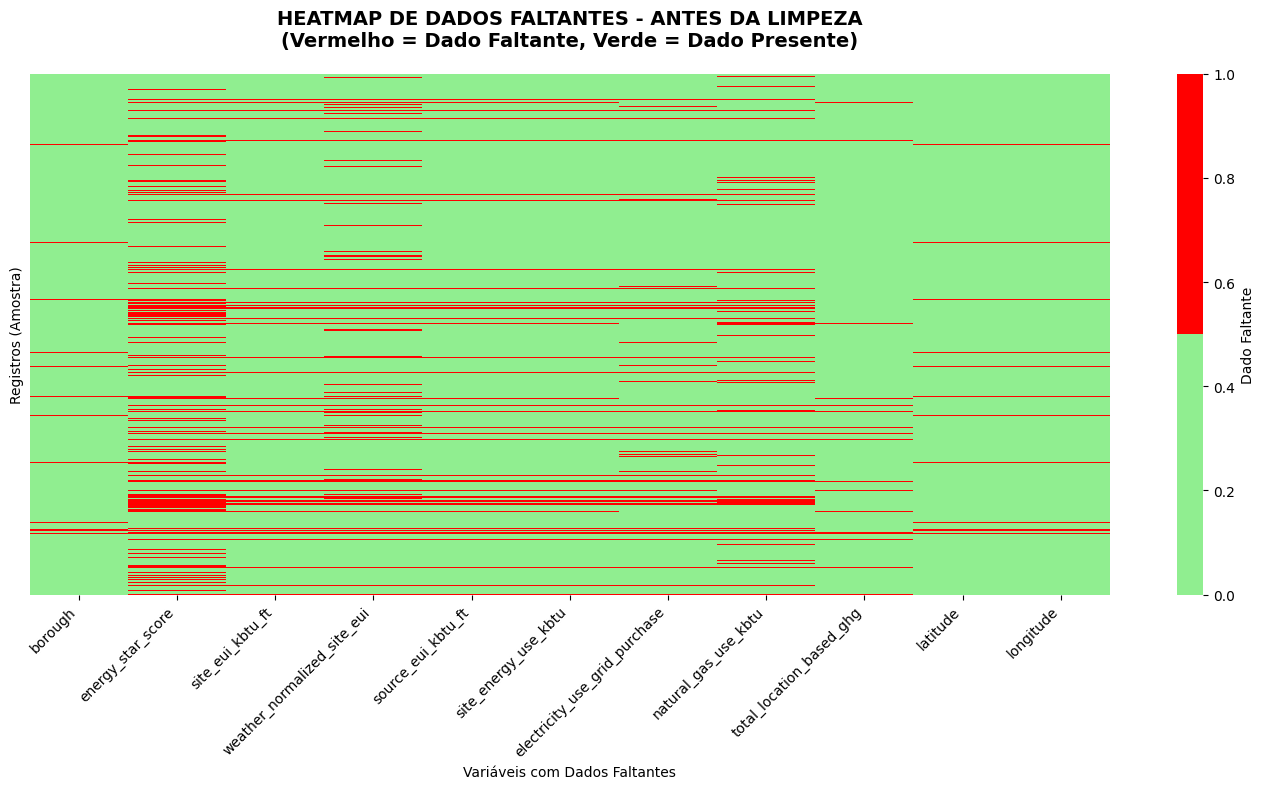


ANÁLISE QUANTITATIVA DOS DADOS FALTANTES (ANTES):


,Variável,Dados_Faltantes,Percentual_Faltante
1,energy_star_score,15101,23.54
7,natural_gas_use_kbtu,8042,12.54
3,weather_normalized_site_eui,7454,11.62
6,electricity_use_grid_purchase,5137,8.01
2,site_eui_kbtu_ft,4362,6.80
5,site_energy_use_kbtu,4362,6.80
4,source_eui_kbtu_ft,4362,6.80
0,borough,2370,3.70
9,latitude,2373,3.70
10,longitude,2373,3.70



6.2 HEATMAP DE DADOS FALTANTES - APÓS A LIMPEZA


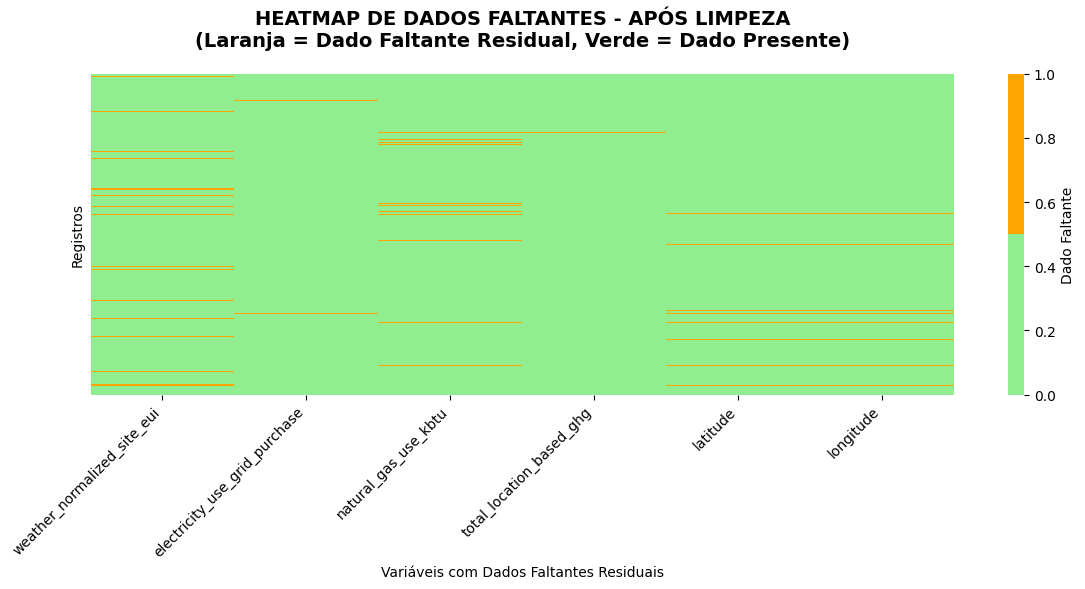

DADOS FALTANTES RESIDUAIS APÓS LIMPEZA:


,Variável,Dados_Faltantes_Residuais,Percentual_Residual
0,weather_normalized_site_eui,2274,5.37
1,electricity_use_grid_purchase,433,1.02
2,natural_gas_use_kbtu,1825,4.31
3,total_location_based_ghg,6,0.01
4,latitude,1148,2.71
5,longitude,1148,2.71


In [41]:
print("\n6. VISUALIZAÇÕES PARA DIAGNÓSTICO DE QUALIDADE")
print("=" * 50)

# Heatmap de dados faltantes antes da limpeza
print("\n6.1 HEATMAP DE DADOS FALTANTES - ANTES DA LIMPEZA")

# Selecionar colunas com dados faltantes significativos para visualização
missing_before = df_selected.isnull().sum()
cols_with_missing = missing_before[missing_before > 0].index.tolist()

# Criar matriz de dados faltantes para heatmap
missing_matrix = df_selected[cols_with_missing].isnull()

plt.figure(figsize=(14, 8))
sns.heatmap(missing_matrix, cbar=True, cmap=['lightgreen', 'red'], 
            yticklabels=False, cbar_kws={'label': 'Dado Faltante'})
plt.title('HEATMAP DE DADOS FALTANTES - ANTES DA LIMPEZA\n(Vermelho = Dado Faltante, Verde = Dado Presente)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Variáveis com Dados Faltantes')
plt.ylabel('Registros (Amostra)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análise quantitativa dos dados faltantes
print("\nANÁLISE QUANTITATIVA DOS DADOS FALTANTES (ANTES):")
missing_analysis_before = pd.DataFrame({
    'Variável': cols_with_missing,
    'Dados_Faltantes': [missing_before[col] for col in cols_with_missing],
    'Percentual_Faltante': [(missing_before[col]/len(df_selected)*100).round(2) for col in cols_with_missing]
}).sort_values('Percentual_Faltante', ascending=False)

display(missing_analysis_before.head(10))

# Heatmap de dados faltantes após a limpeza
print("\n6.2 HEATMAP DE DADOS FALTANTES - APÓS A LIMPEZA")

missing_after = df_clean.isnull().sum()
cols_with_missing_after = missing_after[missing_after > 0].index.tolist()

if cols_with_missing_after:
    missing_matrix_after = df_clean[cols_with_missing_after].isnull()
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_matrix_after, cbar=True, cmap=['lightgreen', 'orange'], 
                yticklabels=False, cbar_kws={'label': 'Dado Faltante'})
    plt.title('HEATMAP DE DADOS FALTANTES - APÓS LIMPEZA\n(Laranja = Dado Faltante Residual, Verde = Dado Presente)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Variáveis com Dados Faltantes Residuais')
    plt.ylabel('Registros')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("DADOS FALTANTES RESIDUAIS APÓS LIMPEZA:")
    residual_missing = pd.DataFrame({
        'Variável': cols_with_missing_after,
        'Dados_Faltantes_Residuais': [missing_after[col] for col in cols_with_missing_after],
        'Percentual_Residual': [(missing_after[col]/len(df_clean)*100).round(2) for col in cols_with_missing_after]
    })
    display(residual_missing)
else:
    print("✅ NENHUM DADO FALTANTE RESIDUAL ENCONTRADO APÓS LIMPEZA COMPLETA!")


6.3 BOX PLOTS PARA DETECÇÃO DE OUTLIERS - ANTES DA LIMPEZA


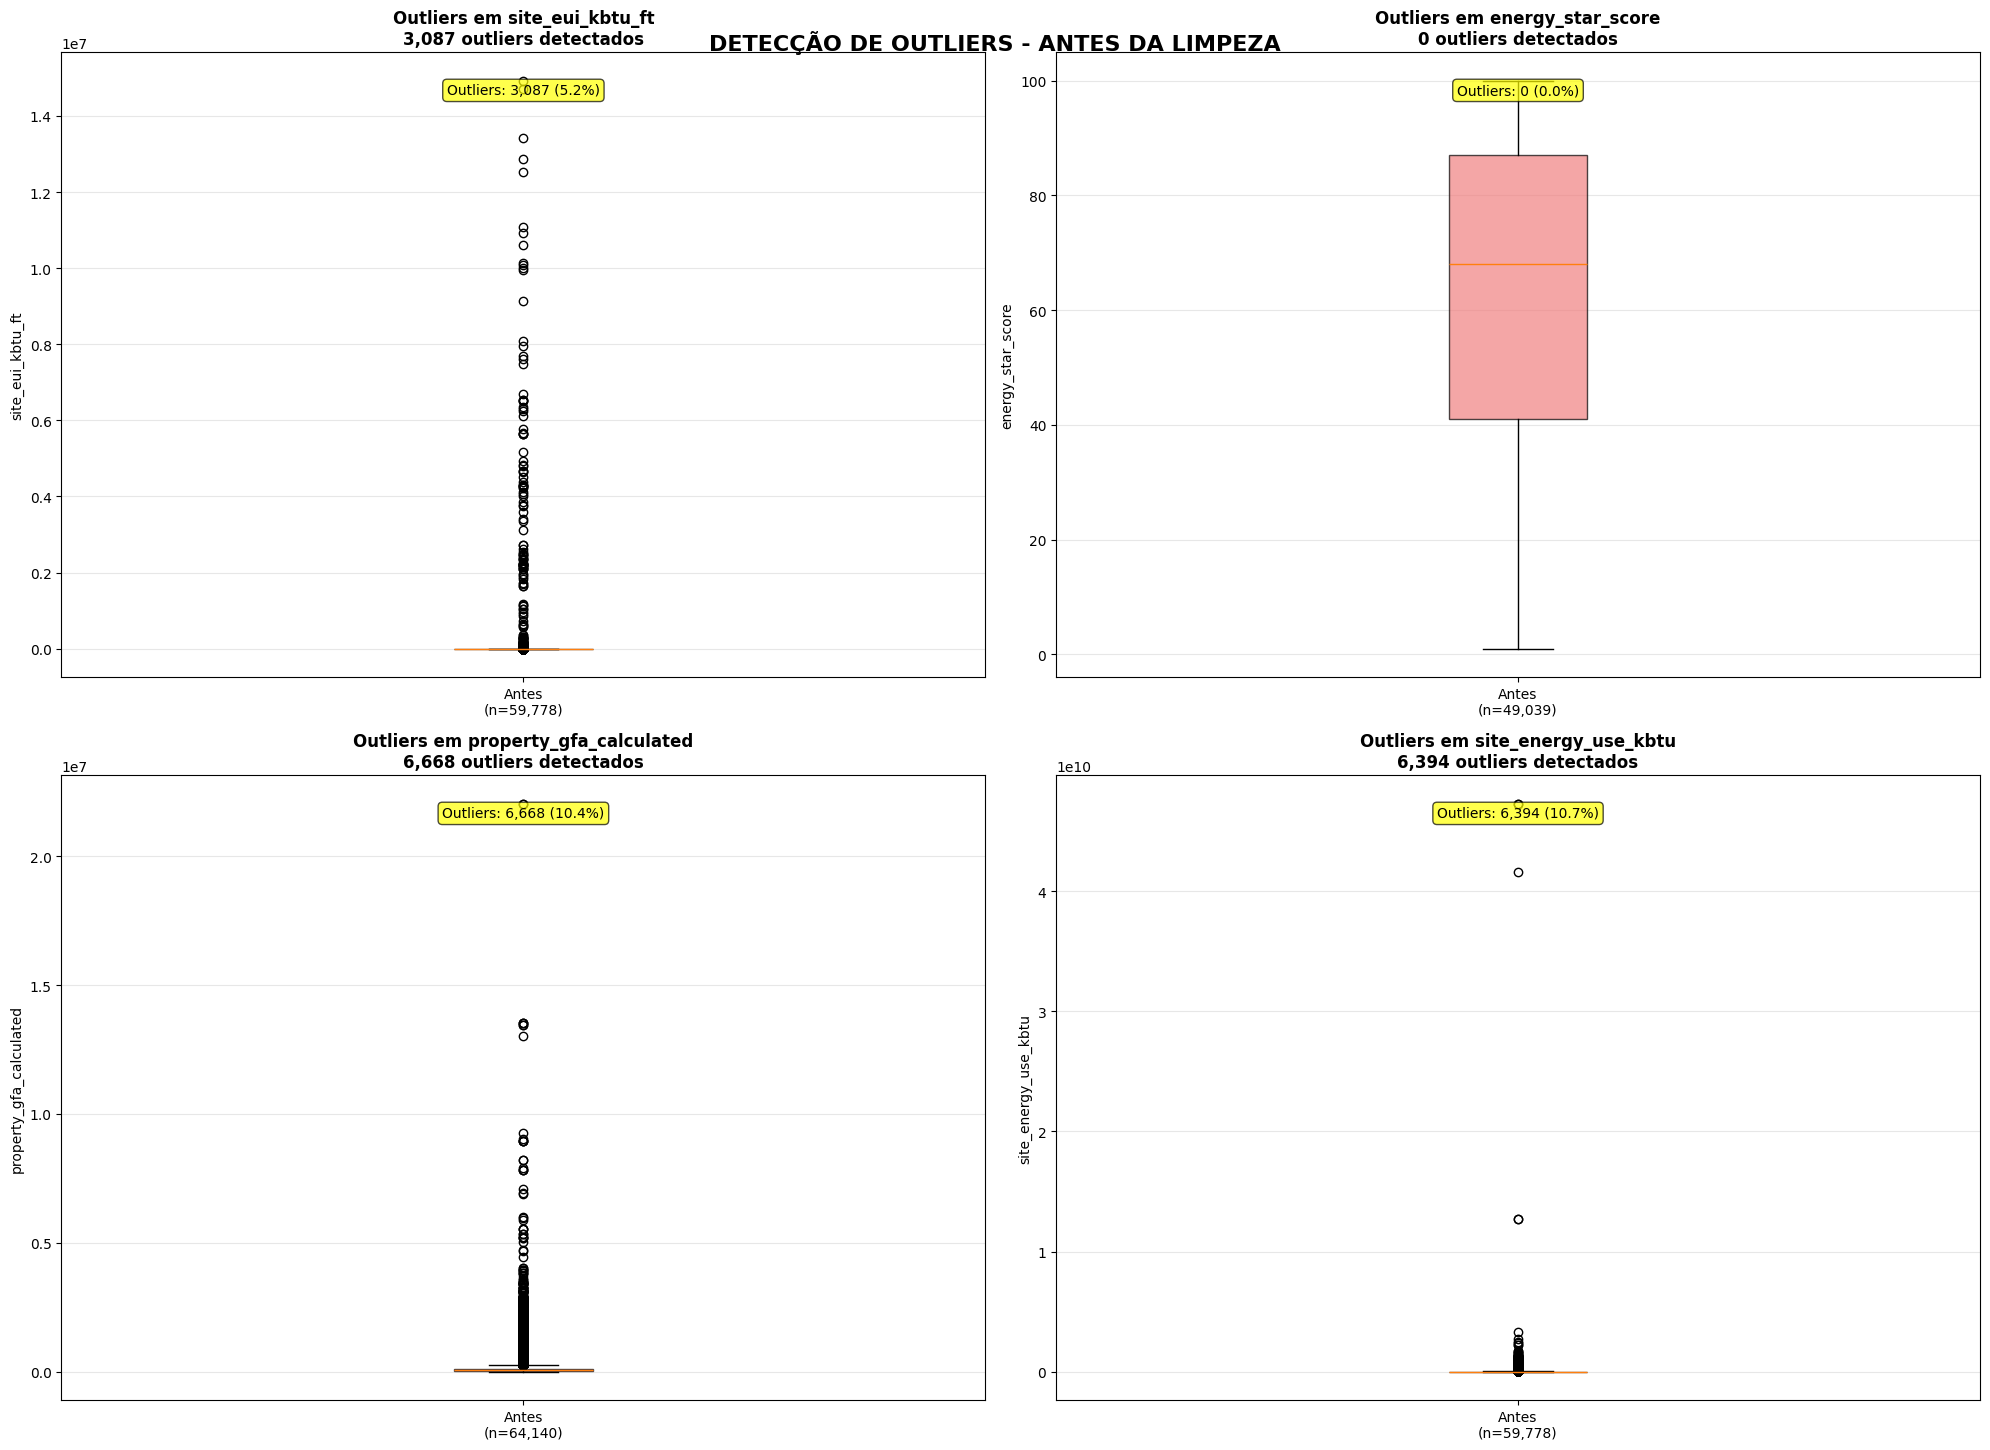


7.4 BOX PLOTS PARA DETECÇÃO DE OUTLIERS - APÓS A LIMPEZA


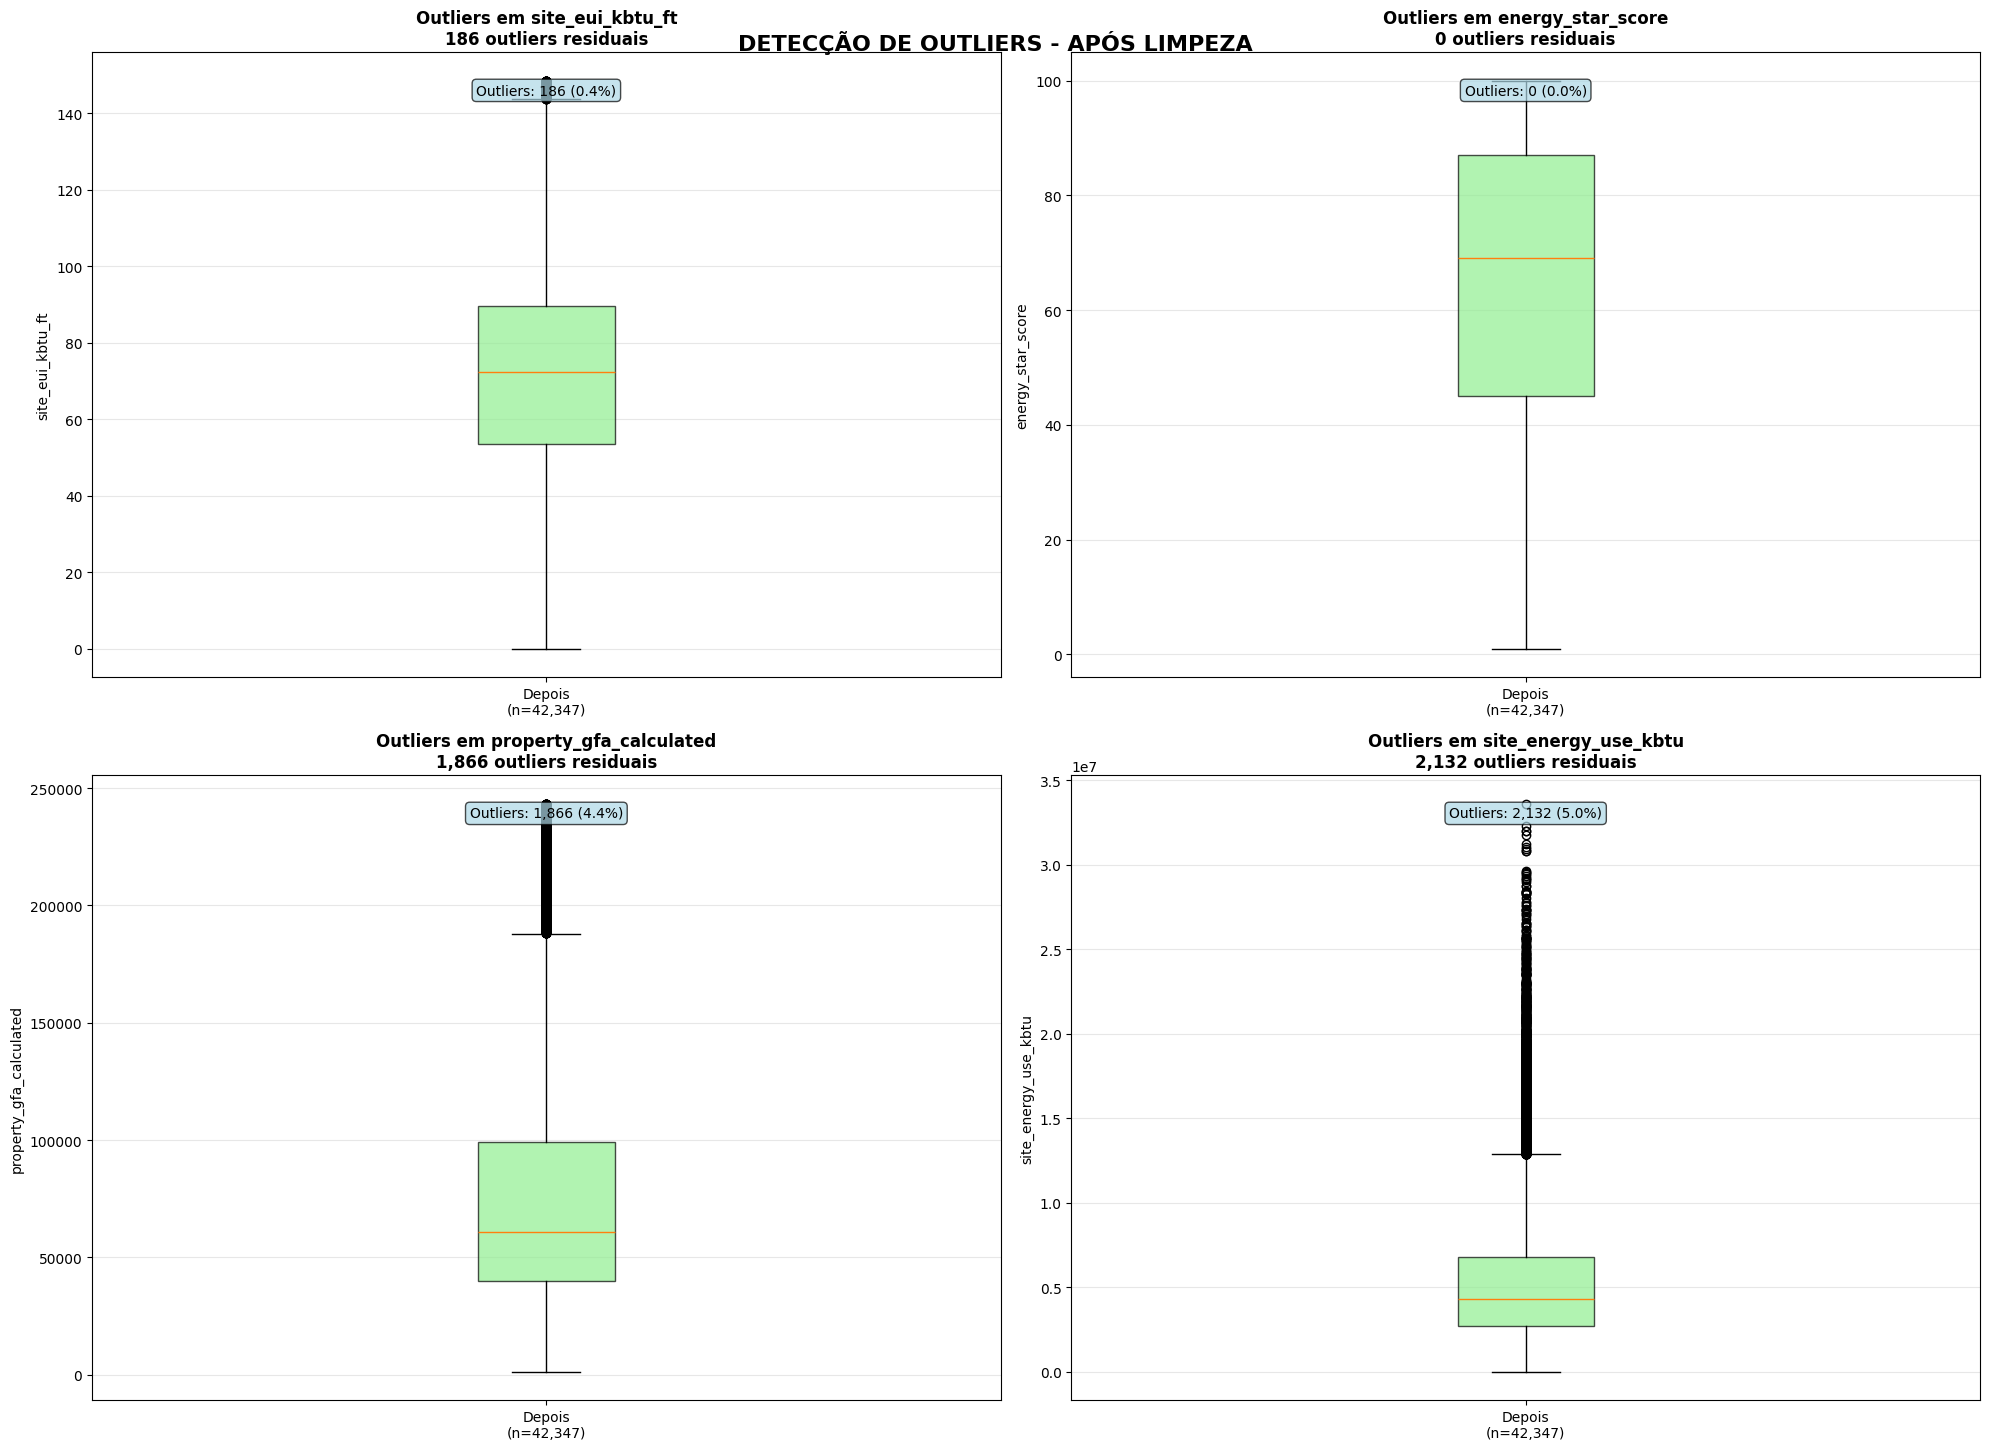

In [ ]:
print("\n6.3 BOX PLOTS PARA DETECÇÃO DE OUTLIERS - ANTES DA LIMPEZA")

# Variáveis numéricas principais para análise de outliers
numeric_vars = ['site_eui_kbtu_ft', 'energy_star_score', 'property_gfa_calculated', 'site_energy_use_kbtu']

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

for i, var in enumerate(numeric_vars):
    row, col = i // 2, i % 2
    
    # Dados antes da limpeza
    data_before = pd.to_numeric(df_selected[var], errors='coerce').dropna()
    
    # Calcular outliers usando IQR
    Q1 = data_before.quantile(0.25)
    Q3 = data_before.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_before = data_before[(data_before < lower_bound) | (data_before > upper_bound)]
    
    # Box plot
    boxplot = axes[row, col].boxplot(data_before, vert=True, patch_artist=True, 
                                    labels=[f'Antes\n(n={len(data_before):,})'])
    
    # Customizar cores
    boxplot['boxes'][0].set_facecolor('lightcoral')
    boxplot['boxes'][0].set_alpha(0.7)
    
    axes[row, col].set_title(f'Outliers em {var}\n{len(outliers_before):,} outliers detectados', 
                           fontweight='bold')
    axes[row, col].set_ylabel(var)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Adicionar anotações
    axes[row, col].text(0.5, 0.95, f'Outliers: {len(outliers_before):,} ({len(outliers_before)/len(data_before)*100:.1f}%)', 
                       transform=axes[row, col].transAxes, ha='center', va='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.suptitle('DETECÇÃO DE OUTLIERS - ANTES DA LIMPEZA', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()


print("\n6.4 BOX PLOTS PARA DETECÇÃO DE OUTLIERS - APÓS A LIMPEZA")

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

for i, var in enumerate(numeric_vars):
    row, col = i // 2, i % 2
    
    # Dados após a limpeza
    data_after = df_clean[var].dropna()
    
    # Calcular outliers residuais
    Q1 = data_after.quantile(0.25)
    Q3 = data_after.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_after = data_after[(data_after < lower_bound) | (data_after > upper_bound)]
    
    # Box plot
    boxplot = axes[row, col].boxplot(data_after, vert=True, patch_artist=True, 
                                    labels=[f'Depois\n(n={len(data_after):,})'])
    
    # Customizar cores
    boxplot['boxes'][0].set_facecolor('lightgreen')
    boxplot['boxes'][0].set_alpha(0.7)
    
    axes[row, col].set_title(f'Outliers em {var}\n{len(outliers_after):,} outliers residuais', 
                           fontweight='bold')
    axes[row, col].set_ylabel(var)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Adicionar anotações
    axes[row, col].text(0.5, 0.95, f'Outliers: {len(outliers_after):,} ({len(outliers_after)/len(data_after)*100:.1f}%)', 
                       transform=axes[row, col].transAxes, ha='center', va='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.suptitle('DETECÇÃO DE OUTLIERS - APÓS LIMPEZA', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()


7.5 COMPARAÇÃO DE OUTLIERS - ANTES VS DEPOIS
COMPARAÇÃO DE OUTLIERS - RESUMO:


,Variável,Outliers_Antes,Outliers_Depois,Redução_Outliers,Percentual_Redução
0,site_eui_kbtu_ft,3087,186,2901,93.974733
1,energy_star_score,0,0,0,100.000000
2,property_gfa_calculated,6668,1866,4802,72.015597
3,site_energy_use_kbtu,6394,2132,4262,66.656240


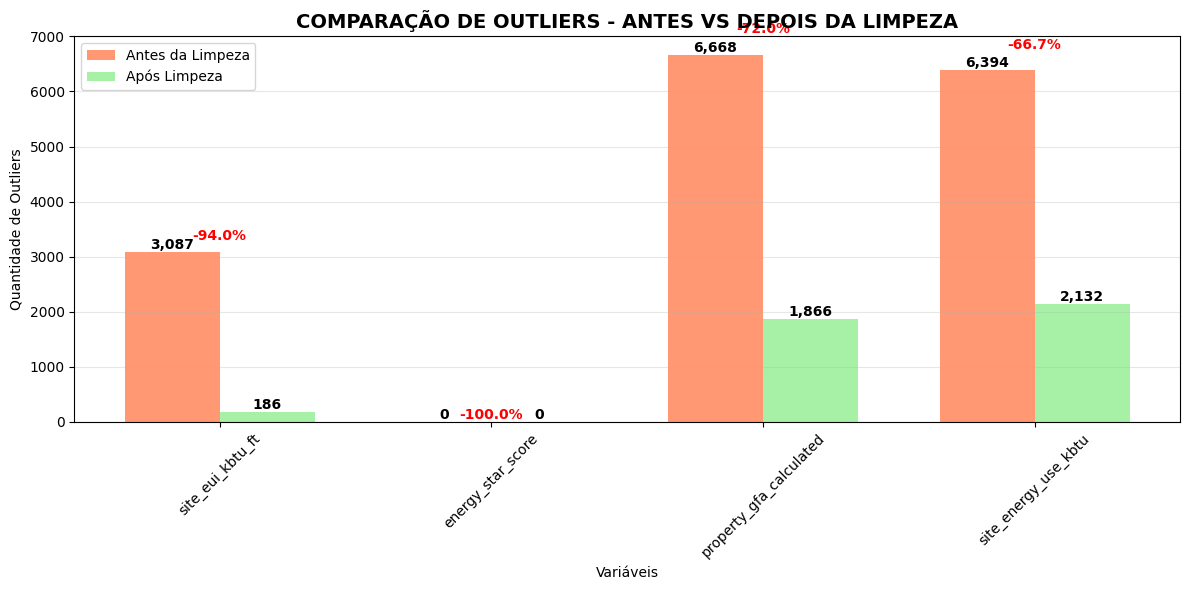

In [ ]:
print("\n6.5 COMPARAÇÃO DE OUTLIERS - ANTES VS DEPOIS")

# Análise comparativa de outliers
outliers_comparison = []

for var in numeric_vars:
    # Antes
    data_before = pd.to_numeric(df_selected[var], errors='coerce').dropna()
    Q1_before = data_before.quantile(0.25)
    Q3_before = data_before.quantile(0.75)
    IQR_before = Q3_before - Q1_before
    outliers_before = data_before[(data_before < Q1_before - 1.5*IQR_before) | 
                                 (data_before > Q3_before + 1.5*IQR_before)]
    
    # Depois
    data_after = df_clean[var].dropna()
    Q1_after = data_after.quantile(0.25)
    Q3_after = data_after.quantile(0.75)
    IQR_after = Q3_after - Q1_after
    outliers_after = data_after[(data_after < Q1_after - 1.5*IQR_after) | 
                               (data_after > Q3_after + 1.5*IQR_after)]
    
    outliers_comparison.append({
        'Variável': var,
        'Outliers_Antes': len(outliers_before),
        'Outliers_Depois': len(outliers_after),
        'Redução_Outliers': len(outliers_before) - len(outliers_after),
        'Percentual_Redução': ((len(outliers_before) - len(outliers_after)) / len(outliers_before) * 100) if len(outliers_before) > 0 else 100
    })

outliers_df = pd.DataFrame(outliers_comparison)
print("COMPARAÇÃO DE OUTLIERS - RESUMO:")
display(outliers_df)

# Gráfico de barras comparativo
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(outliers_df))
width = 0.35

bars1 = ax.bar(x - width/2, outliers_df['Outliers_Antes'], width, label='Antes da Limpeza', color='coral', alpha=0.8)
bars2 = ax.bar(x + width/2, outliers_df['Outliers_Depois'], width, label='Após Limpeza', color='lightgreen', alpha=0.8)

ax.set_xlabel('Variáveis')
ax.set_ylabel('Quantidade de Outliers')
ax.set_title('COMPARAÇÃO DE OUTLIERS - ANTES VS DEPOIS DA LIMPEZA', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(outliers_df['Variável'], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', 
                ha='center', va='bottom', fontweight='bold')

# Adicionar porcentagens de redução
for i, (_, row) in enumerate(outliers_df.iterrows()):
    reduction_pct = row['Percentual_Redução']
    ax.text(x[i], max(row['Outliers_Antes'], row['Outliers_Depois']) * 1.05, 
            f'-{reduction_pct:.1f}%', ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

In [ ]:
print("\n7. EXPORTAÇÃO DO DATASET LIMPO")
print("=" * 50)

# Salvar dataset limpo em formato Parquet
df_clean.to_parquet('nyc_energy_clean_etapa2.parquet', engine='pyarrow', compression='snappy')

# Verificar estrutura final
print("RESUMO FINAL DO DATASET LIMPO:")
print(f"• Registros: {len(df_clean):,}")
print(f"• Colunas: {len(df_clean.columns)}")
print(f"• Tipos de propriedade únicos: {df_clean['primary_property_type'].nunique()}")
print(f"• Boroughs representados: {df_clean['borough'].nunique()}")
print(f"• Faixa de anos de construção: {df_clean['year_built'].min()} - {df_clean['year_built'].max()}")
print(f"• Média do Energy Star Score: {df_clean['energy_star_score'].mean():.1f}")
print(f"• Média do Site EUI: {df_clean['site_eui_kbtu_ft'].mean():.1f} kBTU/ft²")

# Verificar dados faltantes finais
missing_final = df_clean.isnull().sum()
print(f"\nDADOS FALTANTES FINAIS: {missing_final.sum()} valores em todo o dataset")

print("Dataset limpo salvo como: 'nyc_energy_clean.parquet'")


6.6 DISTRIBUIÇÕES COMPARATIVAS - ANTES VS DEPOIS
COMPARAÇÃO DAS DISTRIBUIÇÕES - ANTES VS DEPOIS DA LIMPEZA


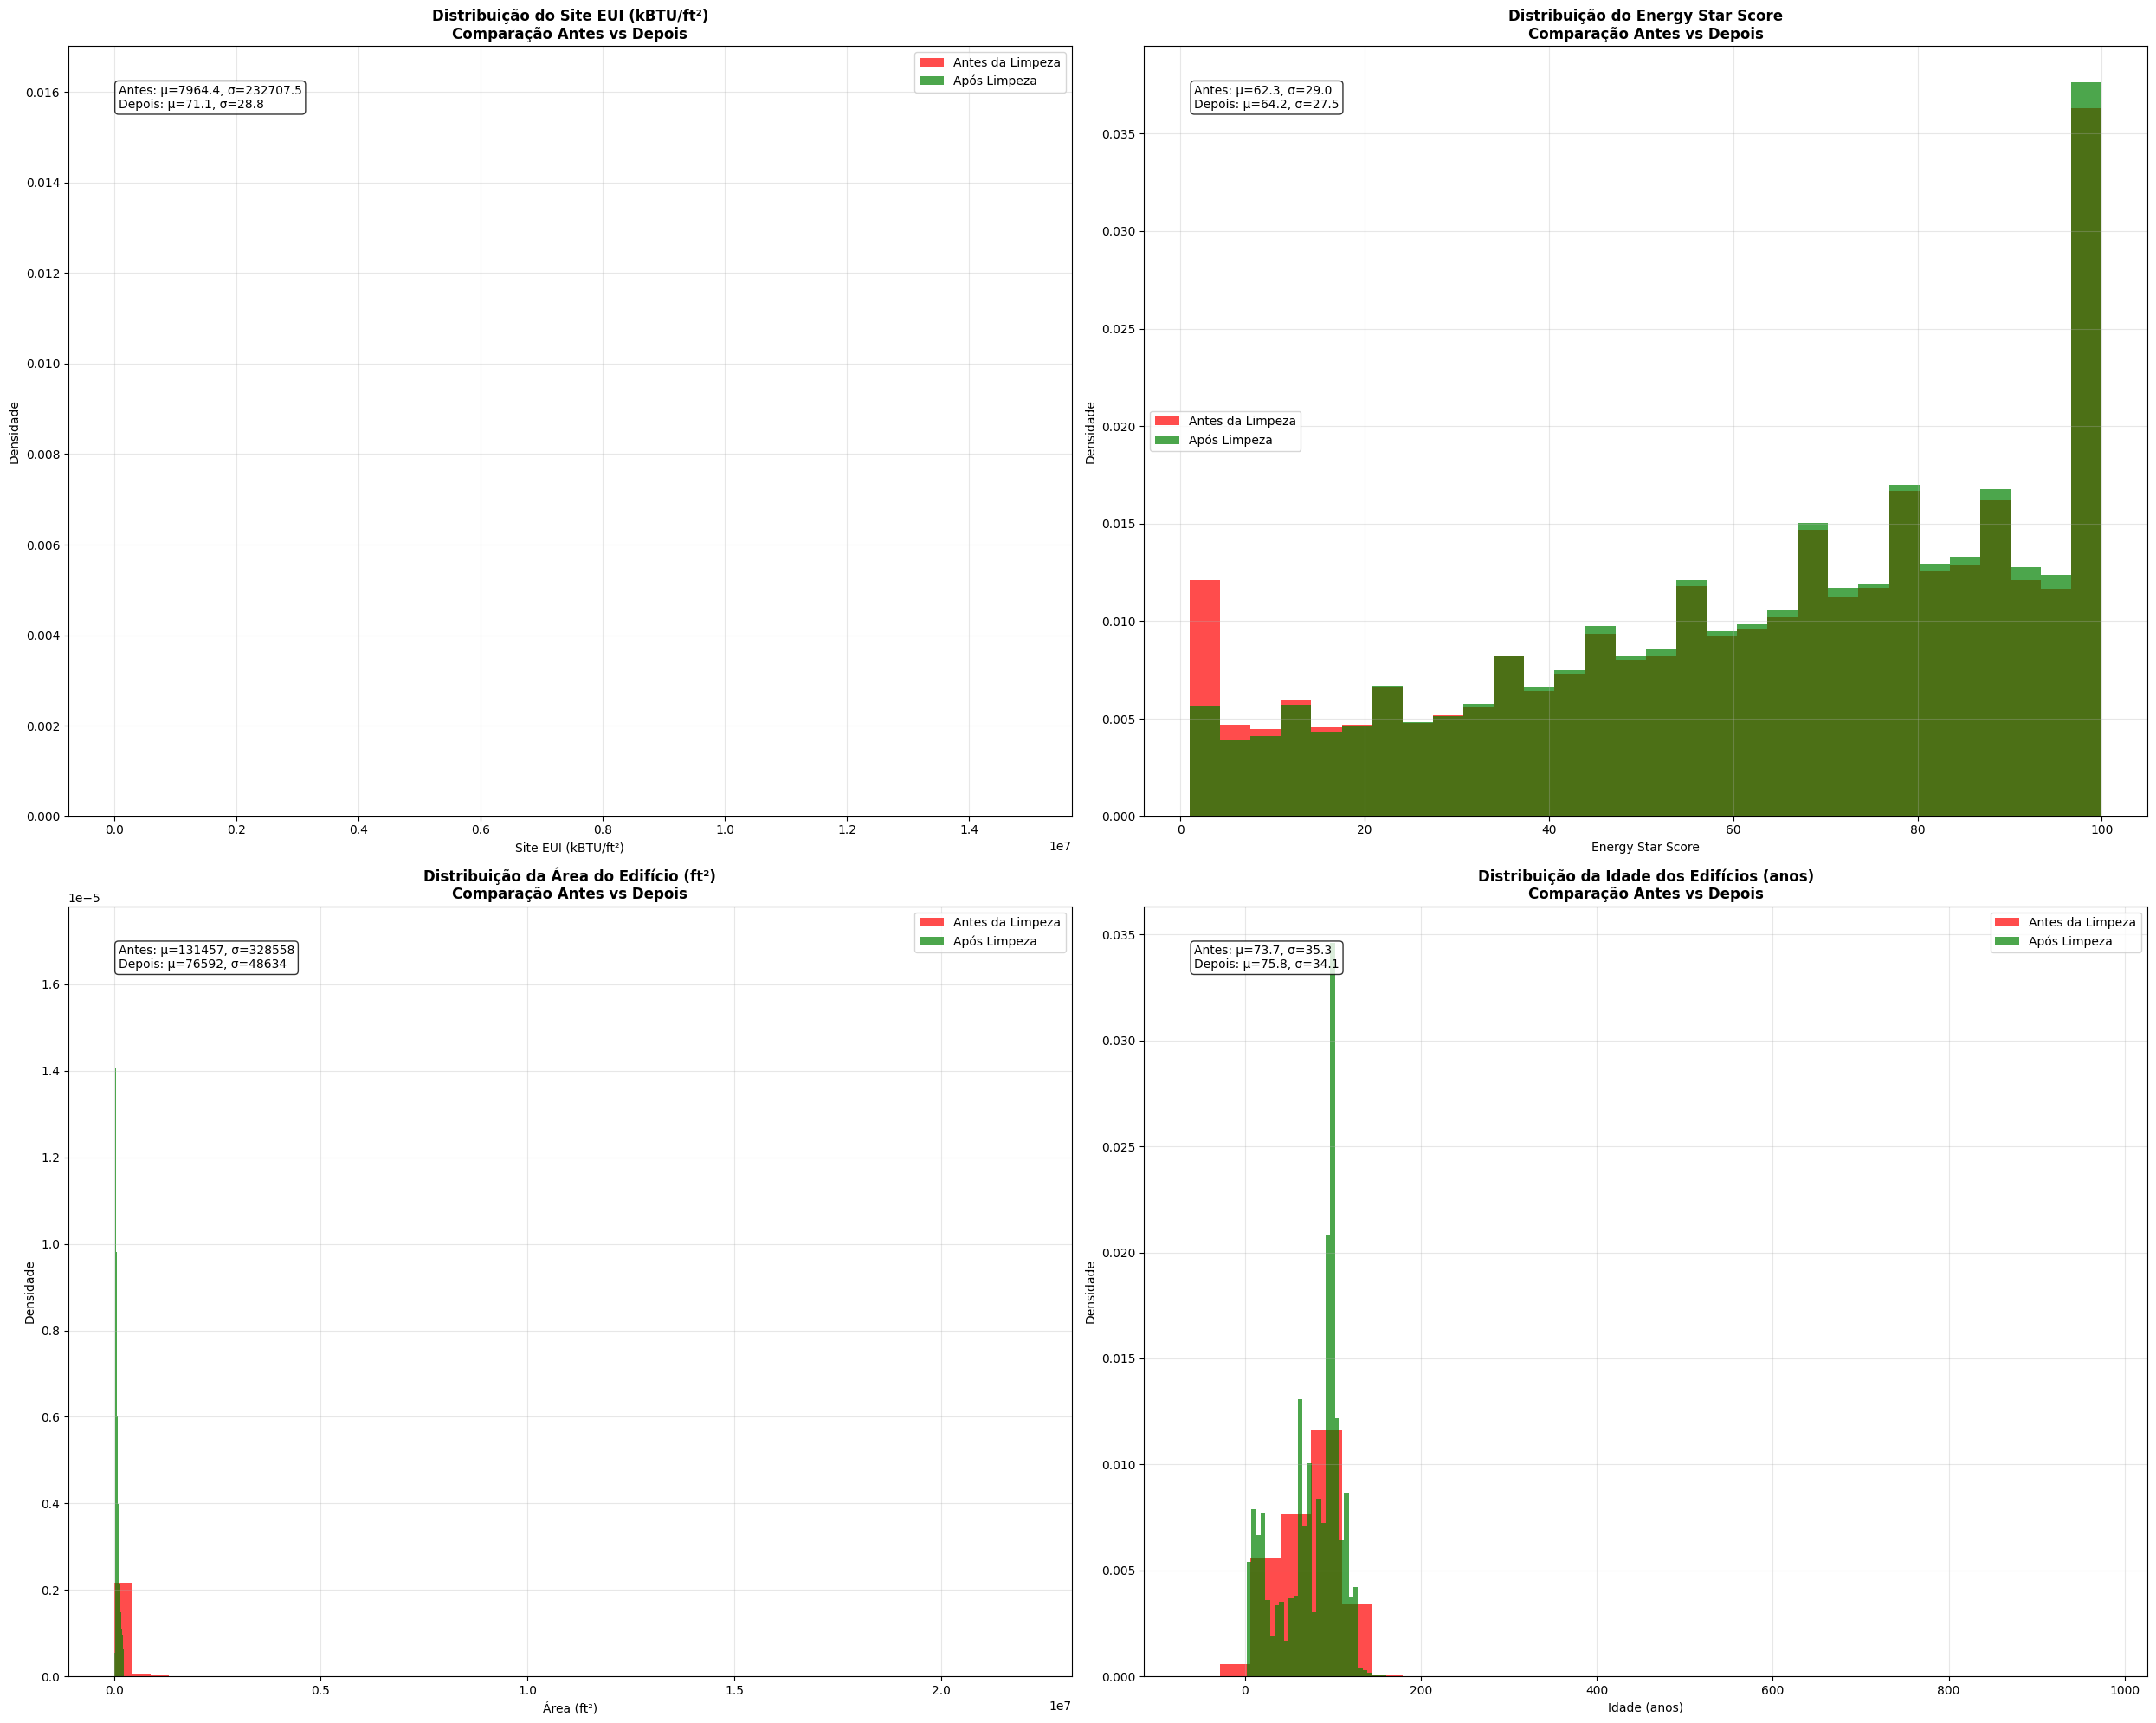

In [60]:
print("\n6.6 DISTRIBUIÇÕES COMPARATIVAS - ANTES VS DEPOIS")

fig, axes = plt.subplots(2, 2, figsize=(25, 20))

# 1. Site EUI
axes[0,0].hist(pd.to_numeric(df_selected['site_eui_kbtu_ft']).dropna(), bins=50, alpha=0.7, 
               color='red', label='Antes da Limpeza', density=True)
axes[0,0].hist(df_clean['site_eui_kbtu_ft'], bins=50, alpha=0.7, 
               color='green', label='Após Limpeza', density=True)
axes[0,0].set_title('Distribuição do Site EUI (kBTU/ft²)\nComparação Antes vs Depois', fontweight='bold')
axes[0,0].set_xlabel('Site EUI (kBTU/ft²)')
axes[0,0].set_ylabel('Densidade')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Adicionar estatísticas
stats_before = pd.to_numeric(df_selected['site_eui_kbtu_ft']).dropna().describe()
stats_after = df_clean['site_eui_kbtu_ft'].describe()
axes[0,0].text(0.05, 0.95, f'Antes: μ={stats_before["mean"]:.1f}, σ={stats_before["std"]:.1f}\nDepois: μ={stats_after["mean"]:.1f}, σ={stats_after["std"]:.1f}', 
               transform=axes[0,0].transAxes, va='top', 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Energy Star Score
axes[0,1].hist(pd.to_numeric(df_selected['energy_star_score']).dropna(), bins=30, alpha=0.7, 
               color='red', label='Antes da Limpeza', density=True)
axes[0,1].hist(df_clean['energy_star_score'], bins=30, alpha=0.7, 
               color='green', label='Após Limpeza', density=True)
axes[0,1].set_title('Distribuição do Energy Star Score\nComparação Antes vs Depois', fontweight='bold')
axes[0,1].set_xlabel('Energy Star Score')
axes[0,1].set_ylabel('Densidade')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

stats_before = pd.to_numeric(df_selected['energy_star_score']).dropna().describe()
stats_after = df_clean['energy_star_score'].describe()
axes[0,1].text(0.05, 0.95, f'Antes: μ={stats_before["mean"]:.1f}, σ={stats_before["std"]:.1f}\nDepois: μ={stats_after["mean"]:.1f}, σ={stats_after["std"]:.1f}', 
               transform=axes[0,1].transAxes, va='top',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 3. Property GFA (área)
axes[1,0].hist(pd.to_numeric(df_selected['property_gfa_calculated']).dropna(), bins=50, alpha=0.7, 
               color='red', label='Antes da Limpeza', density=True)
axes[1,0].hist(df_clean['property_gfa_calculated'], bins=50, alpha=0.7, 
               color='green', label='Após Limpeza', density=True)
axes[1,0].set_title('Distribuição da Área do Edifício (ft²)\nComparação Antes vs Depois', fontweight='bold')
axes[1,0].set_xlabel('Área (ft²)')
axes[1,0].set_ylabel('Densidade')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

stats_before = pd.to_numeric(df_selected['property_gfa_calculated']).dropna().describe()
stats_after = df_clean['property_gfa_calculated'].describe()
axes[1,0].text(0.05, 0.95, f'Antes: μ={stats_before["mean"]:.0f}, σ={stats_before["std"]:.0f}\nDepois: μ={stats_after["mean"]:.0f}, σ={stats_after["std"]:.0f}', 
               transform=axes[1,0].transAxes, va='top',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 4. Building Age
df_selected_age = current_year - pd.to_numeric(df_selected['year_built'], errors='coerce')
axes[1,1].hist(df_selected_age.dropna(), bins=30, alpha=0.7, 
               color='red', label='Antes da Limpeza', density=True)
axes[1,1].hist(df_clean['building_age'], bins=30, alpha=0.7, 
               color='green', label='Após Limpeza', density=True)
axes[1,1].set_title('Distribuição da Idade dos Edifícios (anos)\nComparação Antes vs Depois', fontweight='bold')
axes[1,1].set_xlabel('Idade (anos)')
axes[1,1].set_ylabel('Densidade')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

stats_before = df_selected_age.dropna().describe()
stats_after = df_clean['building_age'].describe()
axes[1,1].text(0.05, 0.95, f'Antes: μ={stats_before["mean"]:.1f}, σ={stats_before["std"]:.1f}\nDepois: μ={stats_after["mean"]:.1f}, σ={stats_after["std"]:.1f}', 
               transform=axes[1,1].transAxes, va='top',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

print('COMPARAÇÃO DAS DISTRIBUIÇÕES - ANTES VS DEPOIS DA LIMPEZA')
plt.tight_layout()
plt.show()


6.7 RESUMO FINAL DA QUALIDADE DOS DADOS
RESUMO DA QUALIDADE DOS DADOS:


,Métrica,Antes,Depois,Melhoria,Percentual_Melhoria
0,Total de Registros,64140.0,42347.0,-21793.0,-34.0
1,Dados Faltantes Totais,57391.0,6834.0,-50557.0,-88.1
2,Outliers Site EUI,3087.0,186.0,-2901.0,-94.0
3,Outliers Energy Star,0.0,0.0,0.0,NaN
4,Outliers Área,6668.0,1866.0,-4802.0,-72.0
5,Completude Energy Star,76.5,100.0,23.5,30.7
6,Completude Site EUI,93.2,100.0,6.8,7.3


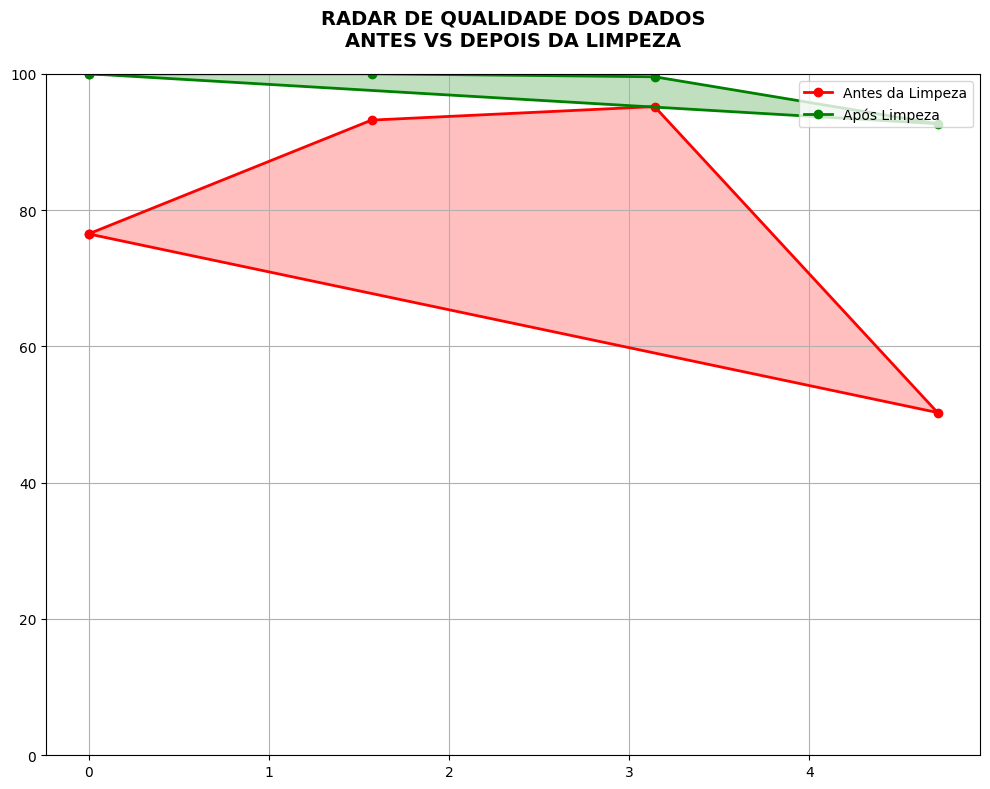

In [64]:
print("\n6.7 RESUMO FINAL DA QUALIDADE DOS DADOS")

# Métricas de qualidade antes e depois
quality_metrics = {
    'Métrica': [
        'Total de Registros',
        'Dados Faltantes Totais', 
        'Outliers Site EUI',
        'Outliers Energy Star',
        'Outliers Área',
        'Completude Energy Star',
        'Completude Site EUI'
    ],
    'Antes': [
        len(df_selected),
        df_selected.isnull().sum().sum(),
        outliers_comparison[0]['Outliers_Antes'],
        outliers_comparison[1]['Outliers_Antes'], 
        outliers_comparison[2]['Outliers_Antes'],
        (df_selected['energy_star_score'].notna().sum() / len(df_selected) * 100).round(1),
        (df_selected['site_eui_kbtu_ft'].notna().sum() / len(df_selected) * 100).round(1)
    ],
    'Depois': [
        len(df_clean),
        df_clean.isnull().sum().sum(),
        outliers_comparison[0]['Outliers_Depois'],
        outliers_comparison[1]['Outliers_Depois'],
        outliers_comparison[2]['Outliers_Depois'],
        (df_clean['energy_star_score'].notna().sum() / len(df_clean) * 100).round(1),
        (df_clean['site_eui_kbtu_ft'].notna().sum() / len(df_clean) * 100).round(1)
    ]
}

quality_df = pd.DataFrame(quality_metrics)
quality_df['Melhoria'] = quality_df['Depois'] - quality_df['Antes']
quality_df['Percentual_Melhoria'] = ((quality_df['Depois'] - quality_df['Antes']) / quality_df['Antes'] * 100).round(1)

print("RESUMO DA QUALIDADE DOS DADOS:")
display(quality_df)

# Gráfico de radar para qualidade geral
fig, ax = plt.subplots(figsize=(10, 8))

metrics_radar = ['Completude\nEnergy Star', 'Completude\nSite EUI', 'Redução\nOutliers', 'Redução\nDados Faltantes']
values_before = [quality_df.loc[5, 'Antes'], quality_df.loc[6, 'Antes'], 
                100 - (outliers_comparison[0]['Outliers_Antes']/len(df_selected)*100), 
                100 - (df_selected.isnull().sum().sum()/(len(df_selected)*len(df_selected.columns))*1000)]
values_after = [quality_df.loc[5, 'Depois'], quality_df.loc[6, 'Depois'],
               100 - (outliers_comparison[0]['Outliers_Depois']/len(df_clean)*100),
               100 - (df_clean.isnull().sum().sum()/(len(df_clean)*len(df_clean.columns))*1000)]

angles = np.linspace(0, 2*np.pi, len(metrics_radar), endpoint=False).tolist()
values_before += values_before[:1]
values_after += values_after[:1]
angles += angles[:1]
metrics_radar += [metrics_radar[0]]

ax.plot(angles, values_before, 'o-', linewidth=2, label='Antes da Limpeza', color='red')
ax.fill(angles, values_before, alpha=0.25, color='red')
ax.plot(angles, values_after, 'o-', linewidth=2, label='Após Limpeza', color='green')
ax.fill(angles, values_after, alpha=0.25, color='green')

ax.set_ylim(0, 100)
ax.set_title('RADAR DE QUALIDADE DOS DADOS\nANTES VS DEPOIS DA LIMPEZA', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right')
ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
print("\n8. DOCUMENTAÇÃO DAS DECISÕES DE LIMPEZA")
print("=" * 50)

cleaning_decisions = {
    "Remoção de registros": "Removidos registros sem Energy Star Score, Site EUI ou tipo de propriedade (variáveis críticas)",
    "Imputação de year_built": "Usada mediana por tipo de propriedade para manter representatividade",
    "Tratamento de borough": "Valores faltantes preenchidos com 'Unknown' para preservar registros",
    "Remoção de outliers": "Aplicado método IQR nas variáveis numéricas principais",
    "Criação de variáveis": "building_age, age_category, energy_star_category para facilitar análise",
    "Conversão de tipos": "Todas as variáveis numéricas convertidas para float/int"
}

for decision, rationale in cleaning_decisions.items():
    print(f"• {decision}: {rationale}")

print(f"\nTaxa de retenção: {len(df_clean)/len(df_selected)*100:.1f}% dos registros originais")